In [1]:
import numpy as np
import pandas as pd
import tracktor as tr
import cv2
import sys
import time
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

## Global parameters
This cell (below) enlists user-defined parameters

In [2]:
# colours is a vector of BGR values which are used to identify individuals in the video
# s_id is spider id and is also used for individual identification
# since we only have two individuals, the program will only use the first two elements from these arrays (s_id and colours)
# number of elements in colours should be greater than n_inds (THIS IS NECESSARY FOR VISUALISATION ONLY)
# number of elements in s_id should be greater than n_inds (THIS IS NECESSARY TO GET INDIVIDUAL-SPECIFIC DATA)
n_inds = 4
s_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
colours = [(0,0,255),(0,255,255),(255,0,255),(0,0,0),(255,255,0),(255,0,0),(0,255,0),(255,255,255)]

# this is the block_size and offset used for adaptive thresholding (block_size should always be odd)
# these values are critical for tracking performance
block_size = 41
offset = 38

# minimum area and maximum area occupied by the animal in number of pixels
# this parameter is used to get rid of other objects in view that might be hard to threshold out but are differently sized
# in this case, the range is wide because males vastly smaller than females
min_area = 5
max_area = 500

# the scaling parameter can be used to speed up tracking if video resolution is too high (use value 0-1)
scaling = 1.0

# kernel for erosion and dilation
# useful since thin spider limbs are sometimes detected as separate objects
kernel = np.ones((5,5),np.uint8)

# mot determines whether the tracker is being used in noisy conditions to track a single object or for multi-object
# using this will enable k-means clustering to force n_inds number of animals
mot = True

# name of source video and paths
video = 'Tadpole'
input_vidpath = '/mnt/ssd1/Documents/Vivek/tracktor/videos/toxtrac_videos/' + video + '.avi'
output_vidpath = '/mnt/ssd1/Documents/Vivek/tracktor/output/toxtrac_videos/' + video + '.mp4'
output_filepath = '/mnt/ssd1/Documents/Vivek/tracktor/output/toxtrac_videos/' + video + '.csv'
codec = 'DIVX' # try other codecs if the default doesn't work ('DIVX', 'avc1', 'XVID') note: this list is non-exhaustive

In [22]:
## Start time
start = time.time()

## Open video
cap = cv2.VideoCapture(input_vidpath)
if cap.isOpened() == False:
    sys.exit('Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file')

## Video writer class to output video with contour and centroid of tracked object(s)
# make sure the frame size matches size of array 'final'
fourcc = cv2.VideoWriter_fourcc(*codec)
output_framesize = (int(cap.read()[1].shape[1]*scaling),int(cap.read()[1].shape[0]*scaling))
out = cv2.VideoWriter(filename = output_vidpath, fourcc = fourcc, fps = 60.0, frameSize = output_framesize, isColor = True)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

last = 0
df = []

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    this = cap.get(1)
    if ret == True:
        frame = cv2.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv2.INTER_LINEAR)
        
        # Apply mask to aarea of interest
        mask = np.zeros(frame.shape)
        mask = cv2.rectangle(mask, (100, 30), (750,585), (255,255,255), -1)
        frame[mask ==  0] = 0
        
        thresh = tr.colour_to_thresh(frame, block_size, offset)
        thresh = cv2.erode(thresh, kernel, iterations = 1)
        thresh = cv2.dilate(thresh, kernel, iterations = 1)
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)
        
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)

        final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, mot, this)

        # Create output dataframe
        for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1], s_id[i]])

        # Display the resulting frame
        out.write(final)
        cv2.imshow('frame', final)
        if cv2.waitKey(1) == 27:
            break
            
    if last == this:
        break
    
    last = this

## Write positions to file
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y','id'])
df.to_csv(output_filepath, sep=',')

## When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

## End time and duration
end = time.time()
duration = end - start
print("--- %s seconds ---" %duration)

--- 93.63386464118958 seconds ---


## Plot tracks
The code below allows you to see individual tracks. By counting the number of jumps in the tracks, one can identify number of false detections.

In [3]:
df = pd.read_csv(output_filepath)
df.head()

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,1.0,119.784211,291.610526,A
1,1,1.0,719.362140,295.617284,B
2,2,1.0,124.821549,567.060606,C
3,3,1.0,469.290389,570.382413,D
4,4,2.0,120.721915,289.178637,A


In [4]:
for num,val in enumerate(np.unique(df['id'])):
    df.loc[df['id'] == val, 'id'] = num

df.head()

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,1.0,119.784211,291.610526,0
1,1,1.0,719.362140,295.617284,1
2,2,1.0,124.821549,567.060606,2
3,3,1.0,469.290389,570.382413,3
4,4,2.0,120.721915,289.178637,0


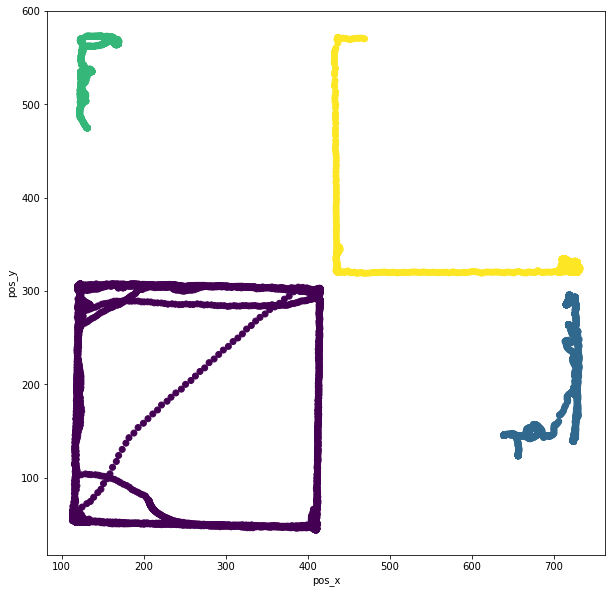

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(df['pos_x'], df['pos_y'], c=df['id'])
plt.xlabel('pos_x')
plt.ylabel('pos_y')
plt.show()

## Identifying true/false detections
Here, we use individual movement speeds to identify false detections. All frames where individuals move faster than their body length are considered false detections.

NOTE: The methode used here underestimates false detections.

In [7]:
dx = df['pos_x'] - df['pos_x'].shift(n_inds)
dy = df['pos_y'] - df['pos_y'].shift(n_inds)
df['speed'] = np.sqrt(dx**2 + dy**2)
df.head()

,Unnamed: 0,frame,pos_x,pos_y,id,speed
0,0,1.0,119.784211,291.610526,0,NaN
1,1,1.0,719.362140,295.617284,1,NaN
2,2,1.0,124.821549,567.060606,2,NaN
3,3,1.0,469.290389,570.382413,3,NaN
4,4,2.0,120.721915,289.178637,0,2.60641


In [8]:
thresh = np.array([34.5, 31.8, 33.3, 31.8])

True detection rate / individual

In [9]:
for i in np.unique(df['id']):
    print(1-len(np.where(df[df['id'] == i]['speed'] > thresh[i])[0]) / max(df['frame']))

1.0
1.0
1.0
1.0
